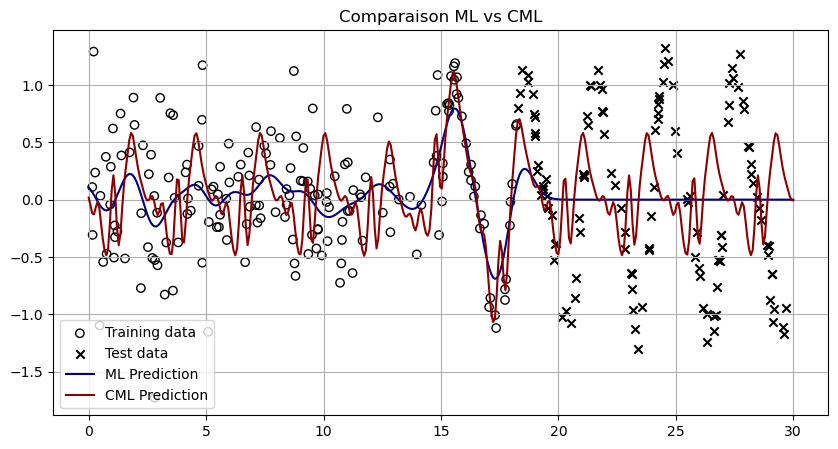

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, ExpSineSquared

def generate_data():
    np.random.seed(42)
    X = np.sort(np.random.rand(300) * 30).reshape(-1, 1) 
    
    y = np.piecewise(X.ravel(), 
                      [X.ravel() < 15, X.ravel() >= 15], 
                      [lambda x: np.random.randn(*x.shape) * 0.5, #Noisy data points
                       lambda x: np.sin(2 * np.pi * (x - 15) / 3) + 0.3 * np.sin(4 * np.pi * (x - 15) / 3)])  #Structured and periodic datas
    
    y += 0.1 * np.random.randn(300)
    split_index = int(0.6 * len(X)) 
    return X[:split_index],  X[split_index:], y[:split_index], y[split_index:]

def train_gp_ml(X_train, y_train):
    #Ajusting hyperparameters of the GP using ML
    kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X_train, y_train)
    return gp

def train_gp_cml(X_train, y_train, m_ratio=0.75):
    #Ajusting hyperparameters of the GP using CML
    m = int(m_ratio * len(X_train))
    X_m, X_rest = X_train[m:], X_train[:m]
    y_m, y_rest = y_train[m:], y_train[:m]
    
    kernel = C(1.0) * (RBF(length_scale=1.0) + ExpSineSquared(length_scale=1.5, periodicity=3.0)) + WhiteKernel(noise_level=0.1)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X_m, y_m)
    return gp

def evaluate_model(gp, X_test, y_test):
    log_likelihood = gp.log_marginal_likelihood()
    y_pred, y_std = gp.predict(X_test, return_std=True)
    mse = np.mean((y_pred - y_test)**2)
    return log_likelihood, mse

def plot_results(gp_ml, gp_cml, X_train, y_train, X_test, y_test):
    X_plot = np.linspace(0, 30, 400).reshape(-1, 1)
    y_pred_ml, std_ml = gp_ml.predict(X_plot, return_std=True)
    y_pred_cml, std_cml = gp_cml.predict(X_plot, return_std=True)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(X_train, y_train, edgecolors='k', facecolors='none', label='Training data')
    plt.scatter(X_test, y_test, color='black', marker='x', label='Test data')
    
    plt.plot(X_plot, y_pred_ml, 'navy', label='ML Prediction')
 
    plt.plot(X_plot, y_pred_cml, 'darkred', label='CML Prediction')

    plt.legend()
    plt.title("Comparaison ML vs CML")
    plt.grid(True)
    plt.savefig("ML_vs_CML.png", dpi=300, bbox_inches='tight')
    plt.show()
    

X_train, X_test, y_train, y_test = generate_data()
gp_ml = train_gp_ml(X_train, y_train)
gp_cml = train_gp_cml(X_train, y_train)

ll_ml, mse_ml = evaluate_model(gp_ml, X_test, y_test)
ll_cml, mse_cml = evaluate_model(gp_cml, X_test, y_test)

plot_results(gp_ml, gp_cml, X_train, y_train, X_test, y_test)
